# Risk Management and The Kelly Criterion
By Gideon Wulfsohn, Delaney Granizo-Mackenzie, and Thomas Wiecki

Part of the Quantopian Lecture Series:

* [quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

The Kelly Criterion is a method that was developed by John Larry Kelly Jr. while working at Bell Labs. Popularized by horse race gamblers and later by investors, the formula can be applied as a useful heuristic when deciding what percentage of your total captial should be allocated to a given strategy.

Lets run through a simple application of the Kelly Criterion which is defined as follows:

**Kelly Optimal Leverage = m<sub>i</sub> / s<sub>i</sub><sup>2</sup>**

* m = mean returns

* s = standard deviation of returns

In [2]:
# get pricing data for S&P 500 over a 13 year timeframe
start = '2002-01-02'
end = '2015-11-09'
df = get_pricing('SPY', fields=['close_price'], start_date=start, end_date=end)

In [3]:
# compute daily returns, add as new column within dataframe
daily_returns = (df.close_price.shift(-1) - df.close_price) / df.close_price
df = df.ix[1:]
df['daily_returns'] = daily_returns

In [4]:
df.head()

,close_price,daily_returns
2002-01-03 00:00:00+00:00,116.76,0.005567
2002-01-04 00:00:00+00:00,117.41,-0.006047
2002-01-07 00:00:00+00:00,116.70,-0.002913
2002-01-08 00:00:00+00:00,116.36,-0.005672
2002-01-09 00:00:00+00:00,115.70,0.002247


In [5]:
# compute mean and sd annual return using daily returns(252 trading days per year)
mean_annual_return = df.daily_returns.mean() * 252
annualized_std = df.daily_returns.std() * (252**.5)
print mean_annual_return
print annualized_std

0.0609729006529
0.196057542257


In [6]:
mean_excess_return = mean_annual_return - .04
sharpe_ratio = mean_excess_return / annualized_std

opt_leverage = mean_excess_return / (annualized_std**2)

In [7]:
print "Sharpe Ratio: {}".format(sharpe_ratio)
print "Kelly Optimal Leverage: {}".format(opt_leverage)

Sharpe Ratio: 0.106973189664
Kelly Optimal Leverage: 0.545621394786


In [8]:
capital = 100000
purchase = int(capital * opt_leverage)
print "If the kelly optimal leverage is {} and you have ${} to invest, you should \
buy ${} worth of SPY under the assumption you believe the \
expected values of your returns by viewing them as gaussian.".format(opt_leverage, capital, purchase)

If the kelly optimal leverage is 0.545621394786 and you have $100000 to invest, you should buy $54562 worth of SPY under the assumption you believe the expected values of your returns by viewing them as gaussian.


# Mean-Varience Example

In [9]:
import math
import numpy as np
import cvxopt as opt
import matplotlib.pyplot as plt
from cvxopt import blas, solvers

In [10]:
np.random.seed(89)

In [11]:
# prevent cvxopt progress from printing
solvers.options['show_progress'] = False

# num assets
n = 4

# number of observations
nobs = 1000

def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.randn(n)
    return k / sum(k)

def gen_returns(asset_count, nobs, drift=0.0):
    ''' 
    Creates normally distributed series 
    :params:
        asset_count: <int> number of series to create
        nobs: <int> number of observations
        drift: <float> skews the distribution to one side
    :returns:
        np.ndarray with <asset_count> rows and <nobs> columns
    '''
    return np.random.randn(asset_count, nobs) + drift
    
def random_portfolio(returns, weight_func):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    w = weight_func(returns.shape[0])
    mu = np.dot(np.mean(returns, axis=1) , w)
    sigma = math.sqrt(np.dot(w, np.dot(np.cov(returns), w)))
    # This recursion reduces outliers
    if sigma > 2:
        return random_portfolio(returns, weight_func)
    return sigma, mu

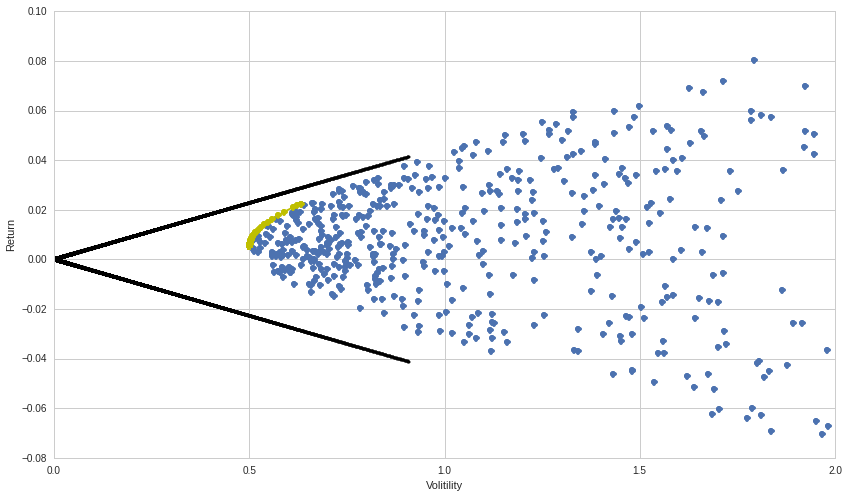

In [12]:
# gather returns and plot

return_vec = gen_returns(n, nobs, drift=0.01)
stds, means = np.column_stack(
    [random_portfolio(return_vec, rand_weights) for _ in xrange(500)]
)

f, ax = plt.subplots()

plt.plot(stds, means, 'o')
ax.set_xlabel('Volitility')
ax.set_ylabel('Return')

# convert to matrix
k = np.array(return_vec)
S = opt.matrix (np.cov(k))
pbar = opt.matrix(np.mean(k, axis=1))

# conditioning optimizer
G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
h = opt.matrix(0.0, (n ,1))
A = opt.matrix(1.0, (1, n))
b = opt.matrix(1.0)

# expected returns
N = 100
mus = [10**(5.0* t/N - 1.0) for t in range(N)]

# efficient frontier weights
portfolios = [
    solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
    for mu in mus
]

# risk and return
returns = [blas.dot(pbar, x) for x in portfolios]
risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
plt.plot(risks, returns, 'y-o')

def get_kelly_portfolios():
    ww = np.dot(np.linalg.inv(opt.matrix(S)), opt.matrix(pbar))
    rks = []; res = [];
    for i in np.arange(0.05, 20, 0.0001):
        w = ww / i
        rks.append(blas.dot(pbar, opt.matrix(w)))
        res.append(np.sqrt(blas.dot(opt.matrix(w), S*opt.matrix(w))))
    return res, rks

res, rks = get_kelly_portfolios()
    
# display kelly portfolios for various leverages
plt.plot(res, rks, 'ko', markersize=3)
plt.plot(res, np.array(rks) * -1, 'ko', markersize=3);